In [165]:
import cv2
import os
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from skimage.feature import hog

In [166]:
ImagePath = 'DataSets/DataSetCopy.csv' #'DataSets/DataSet.csv'
ImageNames = pd.read_csv(ImagePath, header=0, index_col=False)
ImageNames['file'] = ImageNames['file'].apply(lambda x: 'DataSets/files/1/'+x )

In [167]:
#print(ImageNames)

In [168]:
ImageNames['people'].unique()

array([3, 1, 2, 4, 5, 0, 6])

(256, 256)


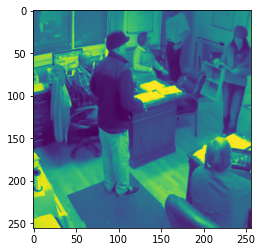

In [169]:
img = cv2.imread('DataSets/files/1/1_331.png', cv2.IMREAD_GRAYSCALE)#ImageNames.iloc[0].tolist()[0])
print(img.shape)
#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gray)
plt.imshow(img)
#kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#img2 = cv2.filter2D(img, -1, kernel)

In [170]:
"""
#creating hog features
fd, hog_image1 = hog(img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(4, 4), visualize=True, multichannel=True)
#creating hog features
fd, hog_image2 = hog(img2, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(4, 4), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image1, cmap="gray")
#plt.axis("off")
#plt.imshow(hog_image2, cmap="gray")
"""

'\n#creating hog features\nfd, hog_image1 = hog(img, orientations=9, pixels_per_cell=(8, 8),\n                \tcells_per_block=(4, 4), visualize=True, multichannel=True)\n#creating hog features\nfd, hog_image2 = hog(img2, orientations=9, pixels_per_cell=(8, 8),\n                \tcells_per_block=(4, 4), visualize=True, multichannel=True)\nplt.axis("off")\nplt.imshow(hog_image1, cmap="gray")\n#plt.axis("off")\n#plt.imshow(hog_image2, cmap="gray")\n'

In [171]:
"""
plt.axis("off")
plt.imshow(hog_image2, cmap="gray")
"""

'\nplt.axis("off")\nplt.imshow(hog_image2, cmap="gray")\n'

In [172]:
#print(fd.shape)

In [173]:
#print(hog_image1.shape)

In [174]:
#new = hog_image1.flatten()
#print(new.shape)

In [175]:
len(ImageNames['file'].tolist())

340

In [176]:
def loadData():
    imag = []
    y=[]
    imagDir = ImageNames['file'].tolist()
    ab = ImageNames['people'].tolist()
    a = 0
    for i in imagDir:
        try:
            img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
            #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            #img2 = cv2.filter2D(img, -1, kernel)
            img1 = cv2.resize(img, (256, 256))
            #_, hog_image = hog(img1, orientations=9, pixels_per_cell=(8, 8),
            #        cells_per_block=(4, 4), visualize=True, multichannel=True)
            new = img1.flatten() #hog_image.flatten()
            mag = np.array(new, dtype='float32')
            imag.append(mag)
            y.append(ab[a])
            a +=1 
        except Exception as E:
            print(E,i)
    #print(imag)
    return imag,y
        

In [177]:
X,y = loadData()
#y = ImageNames['people'].tolist()

In [178]:
from sklearn.model_selection import train_test_split

In [179]:
print(len(X))

340


In [180]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=3)

In [181]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB 
# CaterogircalNB  for categorical input variables
#GaussianNB    for continuous input variables 
#Create a Gaussian NB Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)
df=pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df.head()

,Actual,Prediction
0,1,1
1,2,1
2,1,1
3,2,3
4,1,1


In [182]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, recall_score

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred))
# we will use recall metric to check whether data is balanced
print("Recall:",recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.45588235294117646
Recall: 0.45588235294117646


In [183]:
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score 

In [184]:
from sklearn.metrics import accuracy_score 
acc=[]
ker=['linear', 'poly', 'rbf', 'sigmoid']
for i in ker:
  #X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3) # testset is 30%
  model = SVC(kernel=i)
  model.fit(X_train, y_train)
  pred_svc = model.predict(X_test)
  accu=accuracy_score(y_test, pred_svc)
  acc.append(accu)
 
print(acc)

[0.6029411764705882, 0.5294117647058824, 0.6176470588235294, 0.6176470588235294]


In [185]:
import numpy as np
acc=[]
ker=['linear', 'poly', 'rbf', 'sigmoid']
for i in ker:
  mc_acc=[]
  for j in range(20):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=j) # testset is 30%
    model = SVC(kernel=i)
    model.fit(X_train, y_train)
    pred_svc = model.predict(X_test)
    accu=accuracy_score(y_test, pred_svc)  # 
    mc_acc.append(accu) # append accuracy score in each MC run

  acc.append(np.mean(mc_acc)) # mean of accuracy and append it in accuracy in kernel array
 
print(acc)

[0.6088235294117647, 0.625, 0.6779411764705883, 0.6772058823529411]


In [186]:
best = SVC(kernel='poly')
best.fit(X_train, y_train)
#x_input=X
recom = best.predict(X_test)
print('prediction',recom)
#x_input
print('actual',y_test)

prediction [1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 2 1 2 6 1 2 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1]
actual [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 4, 3, 1, 1, 1, 2, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 3, 2, 2, 1, 2, 1, 2]


In [187]:
from sklearn.metrics import accuracy_score,confusion_matrix,\
 classification_report
from sklearn.tree import DecisionTreeClassifier # decision tee algorithm for classification
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score 


In [188]:
def get_models():
  models = dict()
  models['dt_ent'] = DecisionTreeClassifier(criterion='entropy')
  models['Naive_Base']=GaussianNB()
  models['randomforest'] = RandomForestClassifier(n_estimators=60, criterion='entropy')
  return models

In [189]:
import numpy as np
def evaluate_model(model, X, y):
  acc = [] ### Blank vector
  for i in range(100):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=i)  # split dataset
    dt = model.fit(X_train,y_train) # fit the model
    YPred = dt.predict(X_test) # predict
    a = accuracy_score(y_test,YPred) # compute accuracy
    acc.append(a) # append accuracy
    return np.mean(acc)
    

In [190]:
from numpy import mean, std
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print((name, mean(scores),std(scores)))

('dt_ent', 0.47058823529411764, 0.0)
('Naive_Base', 0.29411764705882354, 0.0)
('randomforest', 0.6764705882352942, 0.0)


In [191]:
clf2 = DecisionTreeClassifier(criterion='entropy')# base learner 1
clf1 = GaussianNB()    # base learner 2
# bagging learner 1
rand1 = RandomForestClassifier(n_estimators=60, criterion='entropy')
bagging1 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)
# bagging learner 2
bagging2 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)

In [192]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score

label = ['Naive_Base', 'dt_ent', 'random forest']# 'Bagging DT', 'Bagging NB']
clf_list = [clf2, clf1, rand1]
 

for clf, label  in zip(clf_list, label ):        
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print ("Accuracy:  ",(round(scores.mean(),4), round(scores.std(),3), label))

Accuracy:   (0.5176, 0.112, 'Naive_Base')
Accuracy:   (0.4029, 0.092, 'dt_ent')
Accuracy:   (0.6735, 0.058, 'random forest')


In [28]:
num_est = np.arange(5,50,5)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for i in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=i, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=10, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
bg_clf_cv_mean

[nan, nan, nan, nan, nan, nan, nan, nan, nan]

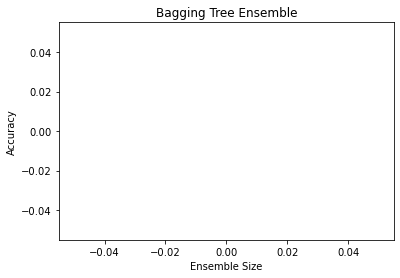

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

In [32]:
from os import listdir
from os.path import isfile, join
mypath = 'DataSets/files/0'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [33]:
#with open ('hello.txt','w+') as f:
#    for i in onlyfiles:
#        f.write(i+'\n')

In [34]:
#with open('hello.txt','r+')as f:
#    a = f.read()
    


In [35]:
#print(type(a))
#b = a.replace(".png", ".jpg")
#print(b)
#with open ('hello.txt','w+') as f:
#    f.write(b)

In [36]:
import cv2
import os
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC

ImagePath1 = 'DataSets/DataSet.csv' #'DataSets/DataSet.csv'
ImageNames1 = pd.read_csv(ImagePath1, header=0, index_col=False)
ImageNames1['file'] = ImageNames1['file'].apply(lambda x: 'DataSets/PNGImages/'+x )

def loadData():
    imag = []
    imagDir = ImageNames1['file'].tolist()
    a = 0
    for i in imagDir:
        img = cv2.imread(i)
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #img2 = cv2.filter2D(img, -1, kernel)
        img1 = cv2.resize(img, (512, 512))
        _, hog_image = hog(img1, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(4, 4), visualize=True, multichannel=True)
        new = hog_image.flatten()
        mag = np.array(new, dtype='float32')
        imag.append(mag)
        a +=1
    #print(imag)
    return imag

In [ ]:
X = loadData()
y = ImageNames1['people'].tolist()

In [193]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression

LR = LinearRegression()

#Train the model using the training sets
LR.fit(X_train, y_train)

#Predict the response for test dataset
y_pre = LR.predict(X_test)
y_pred = np.rint(y_pre)
df=pd.DataFrame({'Actual': y_test, 'Prediction': np.rint(y_pred)})
df.head()

,Actual,Prediction
0,1,0.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,2.0


In [194]:
#model evaluation
rmse = mean_squared_error(y_test, y_pre)
r2 = r2_score(y_test, y_pre)
 
# printing values
print('Slope:' ,LR.coef_)
print('Intercept:', LR.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [2.3345146e-05 1.3588342e-05 1.2844763e-05 ... 3.6842725e-06 6.2313347e-06
 1.9348292e-05]
Intercept: 1.4782689
Root mean squared error:  0.7783101446909034
R2 score:  0.03746827786821638


In [195]:
Acc=[]
for i in range(1):
  #X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) # trainset is 80% ---- testset is 20%
  # create and fit the glm model
  model=LogisticRegression()
  res = model.fit(X_train,y_train)
  #make prediction
  yhat=res.predict(X_test)
  #evaluate the glm 
  acc=accuracy_score(y_test,yhat)
  Acc.append(acc)
print(mean(Acc))
   
## Evaluate predictions

print(  confusion_matrix(y_test, y_pred))

print('accuracy',accuracy_score(y_test, y_pred))

print('precision',precision_score(y_test, y_pred, average='weighted'))
print('recall',recall_score(y_test, y_pred, average='weighted' ))

0.5882352941176471
[[ 0  0  0  0  0  0]
 [ 6 23 17  1  0  0]
 [ 0  7  6  0  0  0]
 [ 1  1  2  2  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  0  0  1]]
accuracy 0.47058823529411764
precision 0.6304554079696395
recall 0.47058823529411764
